In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set(style='whitegrid')

img_dir = '/kaggle/input/car-plate-detection/images'
img_paths = glob(os.path.join(img_dir, '*'))

print(f"Found {len(img_paths)} image files.")

img_data = []

for path in img_paths:
    try:
        img = cv2.imread(path)
        if img is None:
            continue
        h, w = img.shape[:2]
        size_kb = os.path.getsize(path) / 1024
        ext = os.path.splitext(path)[1].lower()
        img_data.append({
            'filename': os.path.basename(path),
            'width': w,
            'height': h,
            'aspect_ratio': round(w / h, 2),
            'file_size_kb': round(size_kb, 2),
            'ext': ext
        })
    except Exception as e:
        print(f"Failed reading {path}: {e}")

df = pd.DataFrame(img_data)
df.head()

Found 433 image files.


,filename,width,height,aspect_ratio,file_size_kb,ext
0,Cars393.png,400,218,1.83,523.92,.png
1,Cars376.png,400,265,1.51,564.38,.png
2,Cars87.png,400,290,1.38,635.40,.png
3,Cars190.png,400,300,1.33,701.68,.png
4,Cars177.png,400,238,1.68,472.89,.png


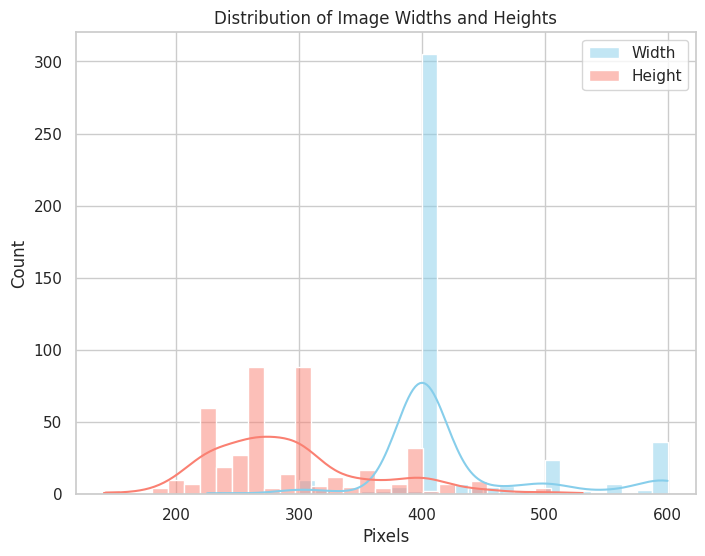

In [3]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='width', bins=30, color='skyblue', label='Width', kde=True)
sns.histplot(data=df, x='height', bins=30, color='salmon', label='Height', kde=True)
plt.legend()
plt.title("Distribution of Image Widths and Heights")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

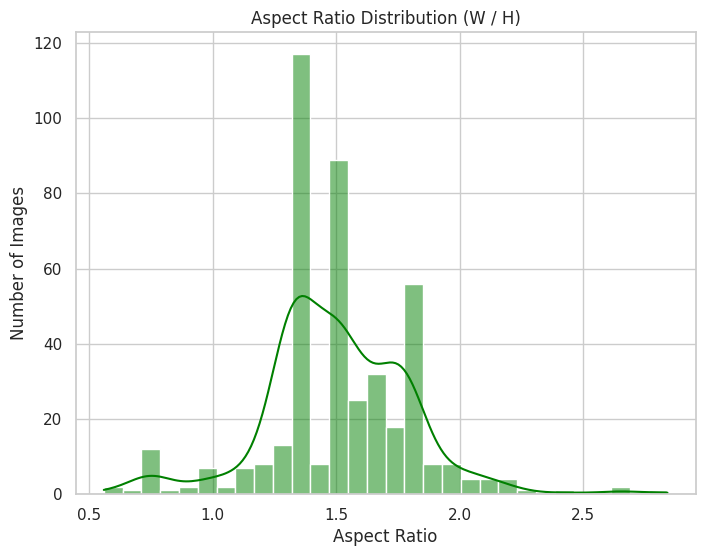

In [4]:
plt.figure(figsize=(8, 6))
sns.histplot(df['aspect_ratio'], bins=30, color='green', kde=True)
plt.title("Aspect Ratio Distribution (W / H)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Number of Images")
plt.show()

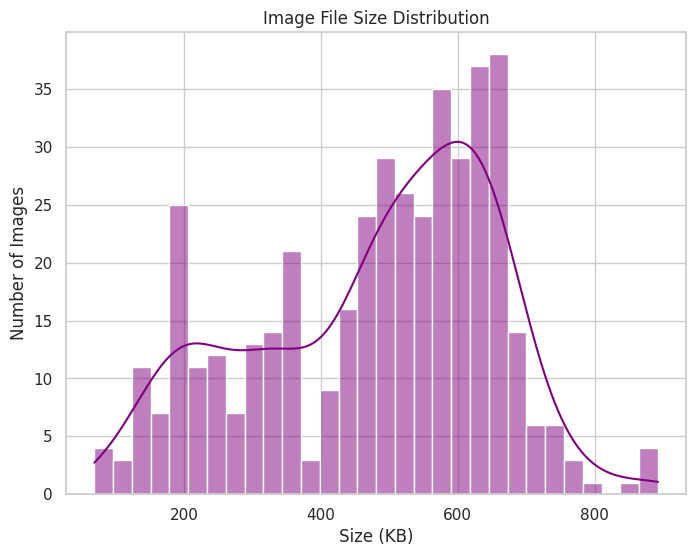

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(df['file_size_kb'], bins=30, color='purple', kde=True)
plt.title("Image File Size Distribution")
plt.xlabel("Size (KB)")
plt.ylabel("Number of Images")
plt.show()

/tmp/ipykernel_55/1622267589.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ext', palette='Set2')


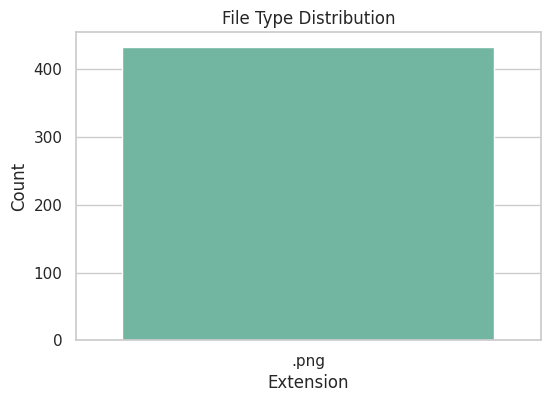

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='ext', palette='Set2')
plt.title("File Type Distribution")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.show()

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from glob import glob

In [11]:
import shutil

In [12]:
p1 = '/kaggle/input/car-plate-detection/annotations'
p2 = '/kaggle/input/number-plate-detection/images'

target_folder = '/kaggle/working/merged_xml'
os.makedirs(target_folder, exist_ok=True)

xml_files_1 = glob(os.path.join(p1, '*.xml'))
xml_files_2 = glob(os.path.join(p2, '*.xml'))

all_xml_files = xml_files_1 + xml_files_2
print(f"[INFO] Found {len(all_xml_files)} .xml files in total.")

for xml_path in all_xml_files:
    filename = os.path.basename(xml_path)
    target_path = os.path.join(target_folder, filename)
    
    if os.path.exists(target_path):
        base, ext = os.path.splitext(filename)
        i = 1
        while os.path.exists(os.path.join(target_folder, f"{base}_{i}{ext}")):
            i += 1
        target_path = os.path.join(target_folder, f"{base}_{i}{ext}")
    
    shutil.copy(xml_path, target_path)

print(f"[SUCCESS] Copied all XML files to: {target_folder}")

[INFO] Found 433 .xml files in total.
[SUCCESS] Copied all XML files to: /kaggle/working/merged_xml


In [13]:
xml_dir = '/kaggle/working/merged_xml'
xml_files = glob(os.path.join(xml_dir, '*.xml'))

print(f"[INFO] Found {len(xml_files)} XML files")

[INFO] Found 433 XML files


In [14]:
annotations = []

for xml_file in xml_files:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        img_filename = root.find('filename').text
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        for obj in root.findall('object'):
            cls_name = obj.find('name').text.strip().lower()
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            box_width = xmax - xmin
            box_height = ymax - ymin
            area = box_width * box_height
            area = box_width * box_height
            rel_area = area / (width * height)

            annotations.append({
                'image': img_filename,
                'class': cls_name,
                'img_width': width,
                'img_height': height,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'box_width': box_width,
                'box_height': box_height,
                'bbox_area': area,
                'rel_area': rel_area
            })
    except Exception as e:
        print(f"[WARN] Failed on {xml_file}: {e}")

In [15]:
df_ann = pd.DataFrame(annotations)
print(f"[INFO] Parsed {len(df_ann)} annotations across {df_ann['image'].nunique()} images")
df_ann.head()

[INFO] Parsed 471 annotations across 433 images


,image,class,img_width,img_height,xmin,ymin,xmax,ymax,box_width,box_height,bbox_area,rel_area
0,Cars214.png,licence,400,243,188,121,214,134,26,13,338,0.003477
1,Cars73.png,licence,400,225,119,22,283,69,164,47,7708,0.085644
2,Cars116.png,licence,400,332,149,218,267,247,118,29,3422,0.025768
3,Cars283.png,licence,400,205,51,189,79,201,28,12,336,0.004098
4,Cars283.png,licence,400,205,137,171,157,178,20,7,140,0.001707


/tmp/ipykernel_55/3901969320.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ann, x='class', order=df_ann['class'].value_counts().index, palette='Set2')


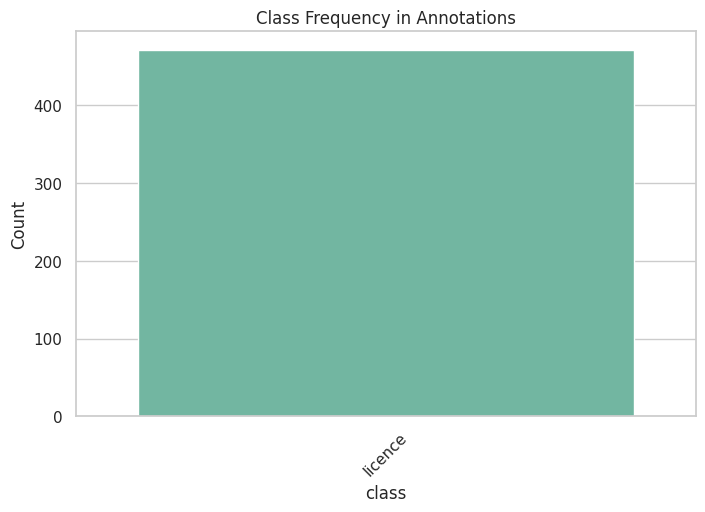

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df_ann, x='class', order=df_ann['class'].value_counts().index, palette='Set2')
plt.title("Class Frequency in Annotations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

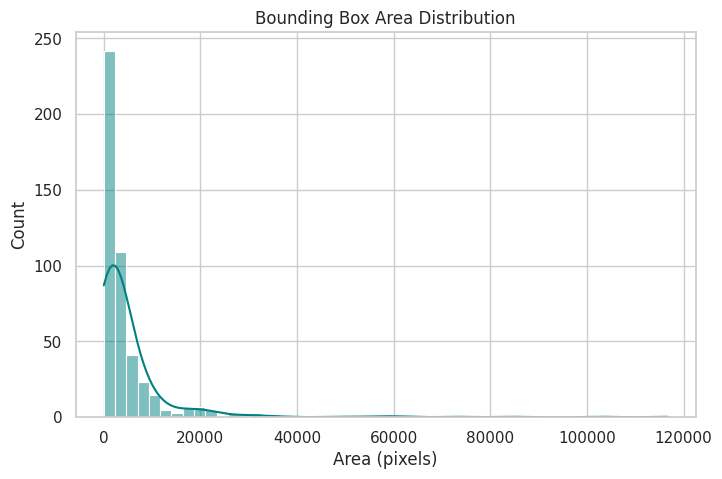

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ann['bbox_area'], bins=50, color='teal', kde=True)
plt.title("Bounding Box Area Distribution")
plt.xlabel("Area (pixels)")
plt.show()

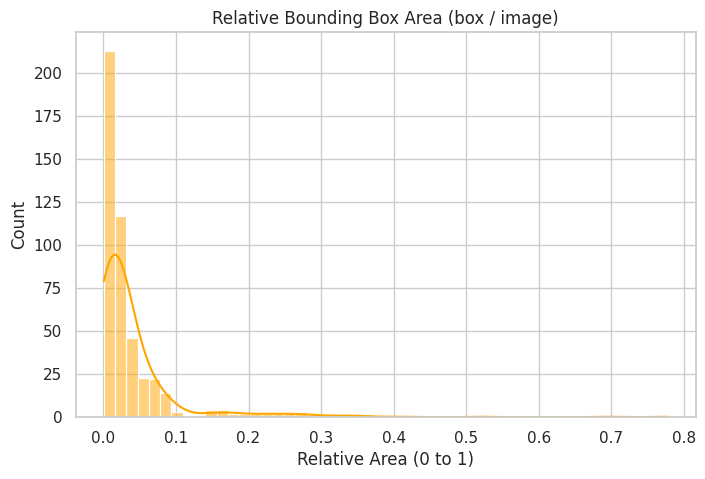

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ann['rel_area'], bins=50, color='orange', kde=True)
plt.title("Relative Bounding Box Area (box / image)")
plt.xlabel("Relative Area (0 to 1)")
plt.show()

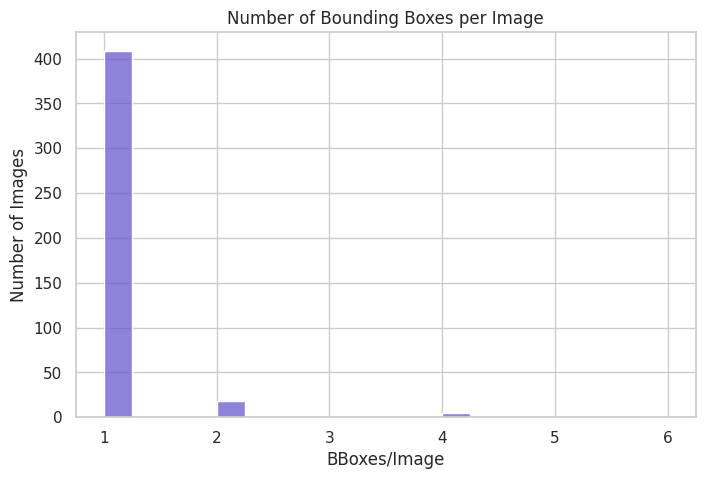

In [19]:
bbox_per_img = df_ann.groupby('image').size()

plt.figure(figsize=(8, 5))
sns.histplot(bbox_per_img, bins=20, color='slateblue', kde=False)
plt.title("Number of Bounding Boxes per Image")
plt.xlabel("BBoxes/Image")
plt.ylabel("Number of Images")
plt.show()